In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
import sys
sys.path.append("../code")
import model_ramp as model
import model_agegroups
import plotting
import parameters
import parameters_agegroups

In [3]:
params_agegroups = parameters_agegroups.get_params(country='Germany', modeltype='ramp', scenario='scenario2')
params_control = parameters.get_params(country='Germany', modeltype='ramp', scenario='scenario2')

In [4]:
#np.array(params_control["y0"])
#params_agegroups["y0"].reshape([18,10]).sum(axis=1)

In [5]:
mAG = model_agegroups.Model(**params_agegroups)
mC = model.Model(**params_control)

In [6]:
start_time = time.time()
times, data = mAG.run()
print(time.time() - start_time)

13.055461168289185


In [7]:
#start_time = time.time()
#times, data = mC.run()
#print(time.time() - start_time)

In [8]:
#np.array(mC.y0)
#np.array(mC.fun(0, mC.y0))

In [9]:
#import importlib
#importlib.reload(model_agegroups)
#importlib.reload(parameters_agegroups)
#params_agegroups = parameters_agegroups.get_params(country='Germany', modeltype='ramp', scenario='scenario2')
#mAG = model_agegroups.Model(**params_agegroups)
#mAG.build_data()
#mAG.fun(0, mAG.y0).reshape([13,10]).sum(axis=1)

In [10]:
mAG.y0.reshape([18,10])[:-4,:].sum(axis=0)

array([100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000.])

In [11]:
Phi_0 = 25000
epsilon_u = 0.1
chi_0 = 0.1
u_base = 0.5
def Phi(u_w, UC):
    if u_w - UC < 0: return 0
#    if u_w - UC > Phi_0/1000000.: return Phi_0
#    if UC < max(u_w - epsilon_u, u_base): return Phi_0
#    return (u_w - UC + epsilon_u)/2./epsilon_u * Phi_0
    return (u_w - UC)*1000000./7.
def Phi_vec(u_w, UC):
#    if UC < max(u_w - epsilon_u, u_base): return Phi_0
#    if UC > min(u_w + epsilon_u, 1-chi_0): return 0
    ramp = np.maximum(np.minimum((u_w - UC + epsilon_u)/2./epsilon_u * Phi_0, Phi_0), 0)
    return ramp * (UC < 1-chi_0) * (UC > u_base) + (UC <= u_base) * Phi_0

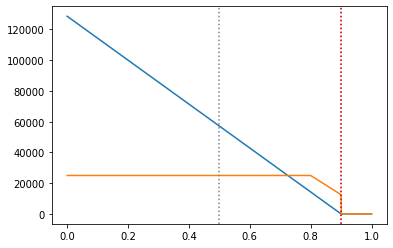

In [12]:
x = np.linspace(0,1,1000)
u_w = np.array([0.9]*1000)
plt.plot(x, list(map(Phi,u_w,x)))
plt.plot(x,Phi_vec(u_w, x))
plt.axvline(u_base, color='gray', ls=':')
plt.axvline(1-chi_0, color='gray', ls=':')
plt.axvline(u_w[0], color='red', ls=':')
plt.show()

In [13]:
x = np.linspace(0,1,6)
u_w = np.array([0.55]*6)

start_time = time.time()
tmp = list(map(Phi, u_w, x))
print(time.time() - start_time)

start_time = time.time()
tmp = Phi_vec(u_w, x)
print(time.time() - start_time)

0.00012254714965820312
0.0001270771026611328


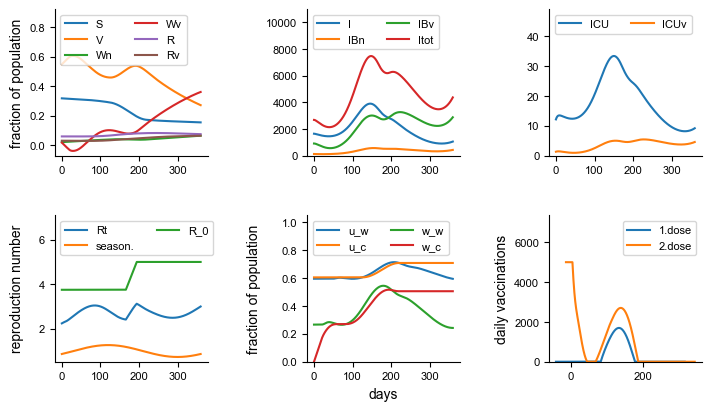

In [14]:
model = mAG
#(S,V,Wn,Wv,E,EBn,EBv,I,IBn,IBv,ICU,ICUv,R,Rv,UC,WC,D,C)

plotting.set_rcParams(arial=True)
t = model.times
data = model.chopped_data()

fig = plt.figure(figsize=(7, 4), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2, hspace=0.2, wspace=0.15)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1],sharex=ax1)
ax3 = fig.add_subplot(grid[2],sharex=ax1)
ax4 = fig.add_subplot(grid[3],sharex=ax1)
ax5 = fig.add_subplot(grid[4],sharex=ax1)
ax6 = fig.add_subplot(grid[5])


ax1.plot(t,data[:,0]/1e6,label="S")
ax1.plot(t,data[:,1]/1e6,label="V")
ax1.plot(t,data[:,2]/1e6,label="Wn")
ax1.plot(t,data[:,3]/1e6,label="Wv")
ax1.plot(t,data[:,12]/1e6,label="R")
ax1.plot(t,data[:,13]/1e6,label="Rv")
#ax1.set_ylim(0,None)
ax1.set_ylabel("fraction of population")
ax1.legend(loc='upper left', ncol=2)

#ax2.plot(t,data[:,4],label="E")
#ax2.plot(t,data[:,5],label="EBn")
#ax2.plot(t,data[:,6],label="EBv")
ax2.plot(t,data[:,7],label="I")
ax2.plot(t,data[:,8],label="IBn")
ax2.plot(t,data[:,9],label="IBv")
ax2.plot(t,data[:,7:10].sum(axis=1),label="Itot")
ax2.set_ylim(0,None)
ax2.legend(loc='upper left', ncol=2)

ax3.plot(t,data[:,10],label="ICU")
ax3.plot(t,data[:,11],label="ICUv")
ax3.set_ylim(0,None)
ax3.legend(loc='upper left', ncol=2)

ax4.plot(t, list(map(model.Rt, t)), label='Rt')
ax4.plot(t, list(map(model.Gamma, t)), label='season.')
ax4.plot(t, list(map(model.R_0, t)), label='R_0')
ax4.set_ylabel("reproduction number")
ax4.legend(loc='upper left', ncol=2)

ax5.plot(t, list(map(model.u_w, t)), label='u_w')
ax5.plot(t, 1/model.M.sum()*data[:,14], label='u_c')
ax5.plot(t, list(map(model.w_w, t)), label='w_w')
ax5.plot(t, 1/data[:,14]*data[:,15], label='w_c')
ax5.set_ylim(0,None)
ax5.set_xlabel("days")
ax5.set_ylabel("fraction of population")
ax5.legend(loc='upper left', ncol=2)

#Phi, phi = model.get_phis(t, data[:,14], data[:,15])
#ax6.plot(t, (Phi*model.M).sum(axis=1), label='1.dose')
#ax6.plot(t, (phi*model.M).sum(axis=1), label='2.dose')
#phis = (np.array(list(map(model.get_phis, t,
#                          model.data[model.time2index(0):-100,14,:],
#                          model.data[model.time2index(0):-100,15,:],
#                          model.data[model.time2index(0):-100,3,:]
#                         )))).sum(axis=2)
AGdata = model.data[model.time2index(0):-100,:,:]
phis = (np.array(list(map(model.get_phis, t, AGdata[:,14,:], AGdata[:,15,:],
                          AGdata[:,3,:]/(AGdata[:,1,:]+AGdata[:,3,:]+AGdata[:,13,:])))))
phis = phis.sum(axis=2)
#ax6.plot(t, (np.array(list(map(model._Phi, t, model.data[model.time2index(0):-100,14,:])))*model.M).sum(axis=1), label='1.willing')
#ax6.plot(t, (np.array(list(map(model._phi, t, model.data[model.time2index(0):-100,15,:])))*model.M).sum(axis=1), label='2.willing')
ax6.plot(t-model.tau_vac1, phis[:,0], label='1.dose')
ax6.plot(t-model.tau_vac2, phis[:,1], label='2.dose')
ax6.set_ylim(0,None)
ax6.set_ylabel("daily vaccinations")
ax6.legend(loc='upper right')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    l,u = ax.get_ylim()
    ax.set_ylim(l,u+0.4*(u-l))

fig.align_ylabels()
    
plt.show()

In [15]:
#plotting.overview(mC)

In [16]:
mAG.chopped_data()[:,:-4].sum(axis=1)+mAG.chopped_data()[:,-2]

array([1000000., 1000000., 1000000., ..., 1000000., 1000000., 1000000.])

In [17]:
list(zip(list((mAG.chopped_data()[-1,:]/1e4).round()),
    ['S','V','Wn','Wv','E','EBn','EBv','I','IBn','IBv','ICU','ICUv','R','Rv','UC','WC','D','C']))

[(16.0, 'S'),
 (27.0, 'V'),
 (6.0, 'Wn'),
 (36.0, 'Wv'),
 (0.0, 'E'),
 (0.0, 'EBn'),
 (0.0, 'EBv'),
 (0.0, 'I'),
 (0.0, 'IBn'),
 (0.0, 'IBv'),
 (0.0, 'ICU'),
 (0.0, 'ICUv'),
 (8.0, 'R'),
 (6.0, 'Rv'),
 (71.0, 'UC'),
 (36.0, 'WC'),
 (0.0, 'D'),
 (17.0, 'C')]

In [18]:
list(zip(list((mAG.chopped_data()[-1,:]/1e4)),
    ['S','V','Wn','Wv','E','EBn','EBv','I','IBn','IBv','ICU','ICUv','R','Rv','UC','WC','D','C']))

[(15.500409097479887, 'S'),
 (27.165841231296625, 'V'),
 (6.4873978692604215, 'Wn'),
 (36.09448448419514, 'Wv'),
 (0.04780972198115931, 'E'),
 (0.01976421516897249, 'EBn'),
 (0.13101068234454152, 'EBv'),
 (0.10574480840739718, 'I'),
 (0.043144511796208804, 'IBn'),
 (0.2878457035298726, 'IBv'),
 (0.0009175808523370502, 'ICU'),
 (0.00045698284503933786, 'ICUv'),
 (7.522559784159095, 'R'),
 (6.468021493110658, 'Rv'),
 (70.71601654923417, 'UC'),
 (35.69959991135802, 'WC'),
 (0.1245918335725864, 'D'),
 (17.01627824896703, 'C')]

In [19]:
mAG.data[-101,3,:]

array([36094.4844842, 36094.4844842, 36094.4844842, 36094.4844842,
       36094.4844842, 36094.4844842, 36094.4844842, 36094.4844842,
       36094.4844842, 36094.4844842])

In [20]:
def Phi(uw, UC):
    ppl = uw - UC
    return ( ppl > 0 ) * ppl / 14.

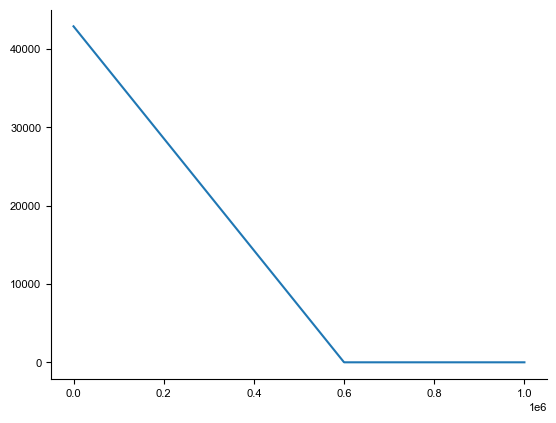

In [21]:
x = np.linspace(0,1e6,1000)
uw = np.array([0.6*1e6]*1000)
plt.plot(x, Phi(uw,x))